In [68]:
"""
Example of computing, logging and alerting using custom metrics for an image dataset.
In this example we will be computing the Brisque score for an OCR data that is available in S3
See image_quality.py to run the same code as a parameterized scheduled job 
"""

import logging
import re
import warnings
from datetime import datetime, timedelta
import domino
from io import BytesIO
import os
from statistics import median

import boto3
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import piq
import rfc3339
import torch
from kats.consts import TimeSeriesData
from kats.detectors.cusum_detection import CUSUMDetector
from matplotlib import pyplot as plt
from tqdm import tqdm

In [69]:
"""
This function uses the kats library to run a cumulative sum analysis to detect changepoint
This function uses a rolling window of data of total size historical_window + scan_window
to detect change points
"""


def get_change_points(metrics_df: pd.DataFrame, historical_window=30,
                      scan_window=7, step=1, plot_cpt=False):
    multi_cp_ts = TimeSeriesData(metrics_df)
    change_points = []
    n_rows = len(metrics_df)
    for end_idx in range(historical_window + scan_window, n_rows, step):
        tsd = multi_cp_ts[end_idx - (historical_window + scan_window): end_idx]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            change_points += CUSUMDetector(tsd).detector(
                interest_window=[historical_window, historical_window + scan_window],
                change_directions=["decrease"])

    if plot_cpt and change_points:
        with warnings.catch_warnings():
            # plot the results
            warnings.simplefilter("ignore")
            detector = CUSUMDetector(multi_cp_ts)  # we are not really using this detector
            detector.detector()  # this call to detector is not being used for anything
            detector.plot(change_points)
            plt.xticks(rotation=45)
            plt.show()

    return change_points


In [70]:
"""
Returns the S3 bucket that contains the OCR dataset
"""


def get_bucket(bucket_name: str):
    try:
        s3_client = boto3.resource(service_name='s3',
                                   aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
                                   aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY']
                                   )
        return s3_client.Bucket(bucket_name)
    except Exception as err:
        logging.error(f"Unable to connect to {bucket_name}")
        raise err


In [71]:
"""
Returns a list of files for which to compute the Brisque score
The latest uploaded folder is picked for processing and the files are organised as
ocr_imgs/folder_name/<img files>
"""


def get_img_keys(bucket_name: str, prefix: str):
    img_files = []
    try:
        ocr_bucket = get_bucket(bucket_name)
        all_ocr_files = ocr_bucket.objects.filter(Prefix=prefix)
        all_ocr_files = [obj.key for obj in sorted(all_ocr_files, key=lambda x: x.last_modified,
                                                   reverse=True)][0:1]
        #
        latest_folder_prefix = [re.sub("/[^/]*$", "/", prefix) for prefix in all_ocr_files][0]

        img_files = ocr_bucket.objects.filter(Prefix=latest_folder_prefix)
        img_files = [obj.key for obj in img_files]
    except Exception as err:
        logging.error(f"Unable to get image file names from {bucket_name}")
        raise err

    return img_files


In [72]:
"""
Reads the files from S3 and computes the median BRISQUE score for all the image
files in the latest folder that has been uploaded to S3
"""


def compute_img_quality(bucket: str, prefix: str):
    ocr_bucket = get_bucket(bucket)
    img_files = get_img_keys(bucket, prefix)
    brisque_scores = []

    for ocr_img_key in tqdm(img_files):
        file_stream = BytesIO()
        try:
            ocr_bucket.Object(ocr_img_key).download_fileobj(file_stream)
            np_img_array = np.frombuffer(file_stream.getbuffer(), dtype="uint8")
            img = cv2.imdecode(np_img_array, cv2.IMREAD_COLOR)
            img_tensor = torch.tensor(img).permute(2, 0, 1)[None, ...] / 255.
            img_quality = piq.brisque(img_tensor, data_range=1., reduction='none')
            brisque_scores.append(img_quality.item())
        except:
            logging.error(f"Unable to process {ocr_img_key}")

    if not brisque_scores:
        return -1

    return median(brisque_scores)


In [73]:
# set the parameters for the rolling window change point and alert generation
fetch_period = 60
show_cpts = True
historical_days = 30
scan_days = 7
step_days = 1
alert_window = 5

# Set the DMM model id and metric name 
modelID = '633f99261c3d57021a6d2827'
metricName = 'Brisque_score'

# Instantiate the custom metrics client
d = domino.Domino(
    "integration-test/Image_Quality_Metrics",
    api_key=os.environ["DOMINO_USER_API_KEY"],
    host=os.environ["DOMINO_API_HOST"],
)
metrics_client = d.custom_metrics_client()

detected_change_points = []

# Uncomment below if you want to actually the Brisque score on a dataset in S3
# Setup S3 access accordingly
# median_brisque_score = compute_img_quality('dmm-cg-1', 'ocr_imgs/')

# Uncomment below if you don't want to compute the BRISQUE score
# The dataset in the above location returns a score thats below
median_brisque_score = 75.3
print('Median Brisque score : %f' % median_brisque_score)

# Log multiple metrics values, we'll log multiple so we can introduce a changepoint

try:
    # Log a single metric value
    #metrics_client.log_metric(modelID, metricName, median_brisque_score, "2022-10-08T00:00:00Z")

    # Log multiple metrics
    metrics_client.log_metrics([
                               { "modelMonitoringId" : modelID, "metric" : metricName, "value" : median_brisque_score,
                                 "timestamp" : "2022-10-12T00:00:00Z"
                                },
                                { "modelMonitoringId" : modelID, "metric" : metricName, "value" : median_brisque_score,
                                  "timestamp" : "2022-10-13T00:00:00Z" }
                                ])
except Exception as err:
    logging.error("Unable to log metric")
    raise err

#Retrieve the stored metrics for the last 3 years 
startDate = datetime.today() - timedelta(days=365*3)
startDate = rfc3339.rfc3339(startDate)
endDate = rfc3339.rfc3339(datetime.today())

# Retrieve the metrics
try:
    res = metrics_client.read_metrics(modelID, metricName,startDate,endDate)
    
except Exception as err:
    logging.error("Unable to fetch metrics")
    raise err

Median Brisque score : 75.300000


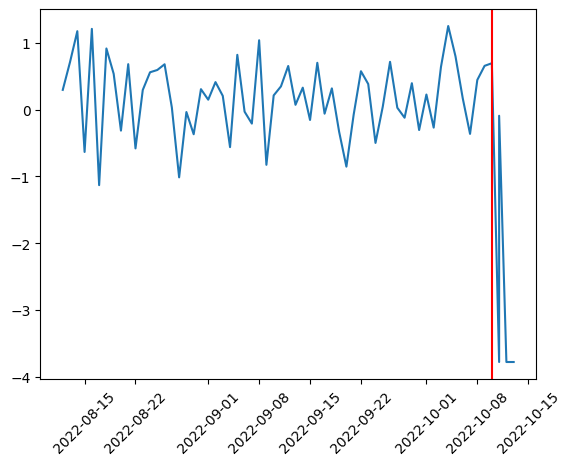

In [74]:
# Prepare a dataframe for change point detection
if res:
    df_image_metrics = pd.DataFrame(res['metricValues']).drop(columns='tags')
    #rename the timestamp column for kats
    df_image_metrics.rename(columns={'timestamp': 'time'}, inplace=True)
    df_image_metrics['time'] = pd.to_datetime(df_image_metrics['time'])
    #drop any duplicates
    df_image_metrics = df_image_metrics.drop_duplicates()
    
    # compute the z-score of the quality metrics
    df_image_metrics['value'] = \
        (df_image_metrics['value'] - df_image_metrics['value'].mean()) \
        / df_image_metrics['value'].std()
    
    df_image_metrics.fillna(-10, inplace=True)
    
    # Get all the change-points for the dataset; you can use your own method to detect deviations
    detected_change_points = get_change_points(df_image_metrics,
                                                historical_window=historical_days,
                                                scan_window=scan_days, step=step_days,
                                                plot_cpt=show_cpts)

In [75]:
if detected_change_points:
    # check for any change points in the last N - alert_window days
    end_check_date = datetime.now(detected_change_points[0].start_time.tzinfo) - timedelta(days=alert_window)
    # extract change point end dates
    cpt_dates = [cpt.end_time for cpt in detected_change_points]
    # check if there are change points in the last alert_window days
    if all(x >= end_check_date for x in cpt_dates):
        # Generate an alert
        print('\nChange point(s) detected at %s' %cpt_dates)
        metrics_client.trigger_alert(modelID, metricName, median_brisque_score,
        condition = metrics_client.LESS_THAN_EQUAL,
        lower_limit= 0.8*median_brisque_score, upper_limit=0.8*median_brisque_score,
        description = "Perceptual quality has degraded" )
else:
    print("No Changepoints detected")


Change point(s) detected at [Timestamp('2022-10-10 00:00:00+0000', tz='UTC')]


Text(0.5, 1.0, 'BRISQUE Time series')

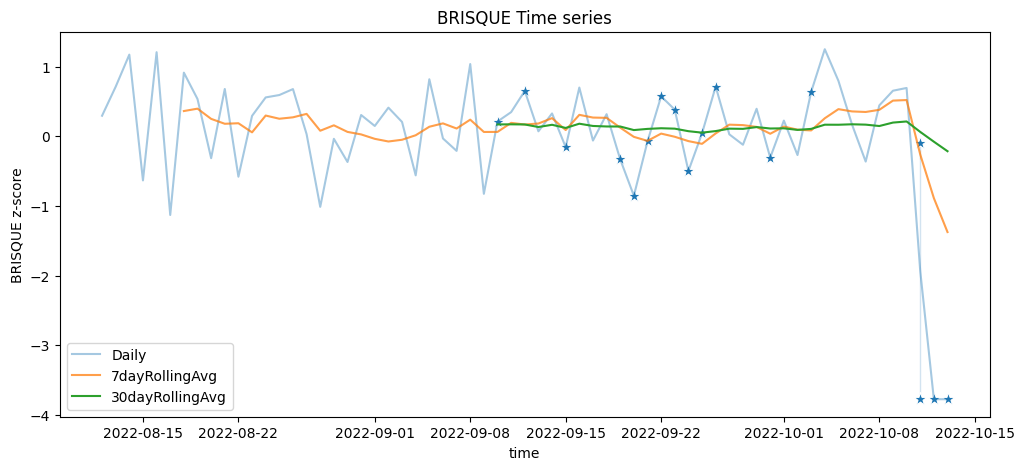

In [76]:
# Find interesting points where quality has changed not necessarily decreases
# check if there are any crossovers between the 7day moving average and the 14 day moving average
# to identify interesting points in the time series to analyze
df_image_metrics['7day_rolling_avg' ] = df_image_metrics.value.rolling(7).mean()
df_image_metrics['30day_rolling_avg' ] = df_image_metrics.value.rolling(30).mean()

plt.figure( figsize = ( 12, 5))
sns.lineplot( x = 'time',
             y = 'value',
             data = df_image_metrics,
             label = 'Daily',alpha =0.4)
  
# plot using rolling average
sns.lineplot( x = 'time',
             y = '7day_rolling_avg',
             data = df_image_metrics,
             label = '7dayRollingAvg', alpha=0.75)

# plot using rolling average
sns.lineplot( x = 'time',
             y = '30day_rolling_avg',
             data = df_image_metrics,
             label = '30dayRollingAvg')

crossovers = np.where(df_image_metrics['7day_rolling_avg'] <= df_image_metrics['30day_rolling_avg'])

if crossovers:
    sns.scatterplot(data=df_image_metrics.iloc[crossovers], x="time", y="value", s=100, marker="*")
    
plt.ylabel('BRISQUE z-score')
plt.title('BRISQUE Time series')